# Building Damage Assessment using ChangeOS
## Apply to tiled Pre_event and Post_event geotif files.


In [ ]:
#install libraries
!pip install changeos
!pip install geopandas
!pip install rasterio

In [9]:
# import some libraries
import rasterio
from rasterio import features
import numpy as np
import changeos

# SINGLE TILE TESTING (TESTING ONLY)

In [30]:
# read in the tiled TIFF files as 3 dimension RGB numpy files FOR THE FIRST TILE of the PRE IMAGE

import rasterio
from PIL import Image

# Open the PRE GeoTIFF file
with rasterio.open('pre_vrt_tiled_v2.tif') as src:
    
    pre_crs = src.crs
    pre_transform = src.transform
    
    # Read the first tile (assuming it's a 3-channel RGB image)
    tile = src.read(1, window=((0, src.block_shapes[0][0]), (0, src.block_shapes[1][0])))

    # Convert the tile to a 3-channel (RGB) image
    pre_tile_rgb = Image.fromarray(tile)
    

    print(pre_tile_rgb)
    
    # Convert the PIL image to a NumPy array
    pre_tile_array = np.array(pre_tile_rgb)

    # Create an empty 3-channel (RGB) array with the same dimensions
    pre_rgb_array = np.empty((pre_tile_array.shape[0], pre_tile_array.shape[1], 3), dtype=np.uint8)

    # Copy the grayscale channel to all three RGB channels
    pre_rgb_array[:,:,0] = pre_tile_array
    pre_rgb_array[:,:,1] = pre_tile_array
    pre_rgb_array[:,:,2] = pre_tile_array

    # Check the shape of the RGB array
    print(pre_rgb_array.shape)
 

<PIL.Image.Image image mode=L size=1024x1024 at 0x7F8A3A35E2F0>


In [32]:
# Read in first tile of the POST image
    
import rasterio
from PIL import Image

# Open the GeoTIFF file
with rasterio.open('post_vrt_tiled_v2.tif') as src:
    # Read the first tile (assuming it's a 3-channel RGB image)
    post_crs = src.crs
    post_transform = src.transform
    
    tile = src.read(1, window=((0, src.block_shapes[0][0]), (0, src.block_shapes[1][0])))

    # Convert the tile to a 3-channel (RGB) image
    post_tile_rgb = Image.fromarray(tile)
    
    print(post_tile_rgb)
    
    # Convert the PIL image to a NumPy array
    post_tile_array = np.array(post_tile_rgb)

    # Create an empty 3-channel (RGB) array with the same dimensions
    post_rgb_array = np.empty((post_tile_array.shape[0], post_tile_array.shape[1], 3), dtype=np.uint8)

    # Copy the grayscale channel to all three RGB channels
    post_rgb_array[:,:,0] = post_tile_array
    post_rgb_array[:,:,1] = post_tile_array
    post_rgb_array[:,:,2] = post_tile_array

    # Check the shape of the RGB array
    print(post_rgb_array.shape)
 

<PIL.Image.Image image mode=L size=1024x1024 at 0x7F8AC0AC0D30>


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


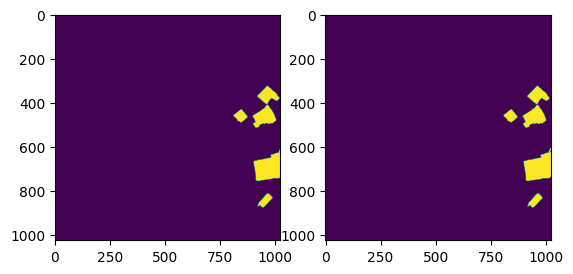

In [34]:
# constructing ChangeOS model and apply to single tile in both images.


# support 'changeos_r18', 'changeos_r34', 'changeos_r50', 'changeos_r101'
model = changeos.from_name('changeos_r101') # take 'changeos_r101' as example
pre_disaster_image = pre_rgb_array
post_disaster_image = post_rgb_array

# model inference
loc, dam = model(pre_disaster_image, post_disaster_image)

# put color map on raw prediction
loc, dam = changeos.visualize(loc, dam)

# visualize by matplotlib
import matplotlib.pyplot as plt

plt.subplot(121)
plt.imshow(loc)
plt.subplot(122)
plt.imshow(dam)
plt.show()

                                            geometry  value
0  POLYGON ((560137.024 3470057.068, 560138.245 3...    1.0
1  POLYGON ((560100.403 3470024.414, 560102.539 3...    1.0
2  POLYGON ((560136.414 3470030.823, 560137.634 3...    1.0
3  POLYGON ((560155.334 3469970.703, 560156.250 3...    1.0
4  POLYGON ((560137.634 3469908.447, 560138.245 3...    1.0


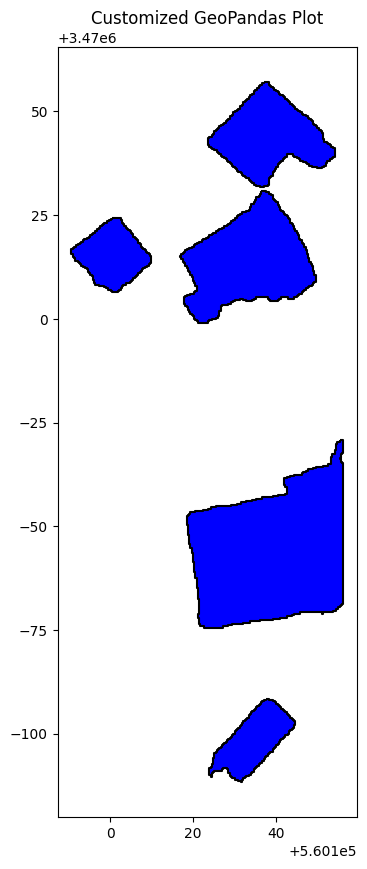

In [42]:
# Extract polgyons from dam (post) and plot them using matplotlib
mask1 = dam!=0
pre_shapes = rasterio.features.shapes(dam, mask=mask1, connectivity=4, transform=post_transform)
pre_fc = ({"geometry": shape, "properties": {"value": value}} for shape, value in pre_shapes)
pre_img_geodf = gpd.GeoDataFrame.from_features(pre_fc)

print(pre_img_geodf)

# Customize the plot
ax = geodf.plot(figsize=(10, 10), color='blue', edgecolor='black', linewidth=1.5)

# Add a title
ax.set_title('Customized GeoPandas Plot')

# Show the plot
plt.show()



In [ ]:
# Okay so that works!!!! 

# BDA for all Tiles
## will take > 1 hour to run all tiles. Use the STOP button then move on.

EPSG:32629
Total number of tiles in the first image: 7857
Total number of tiles in the second image: 7857


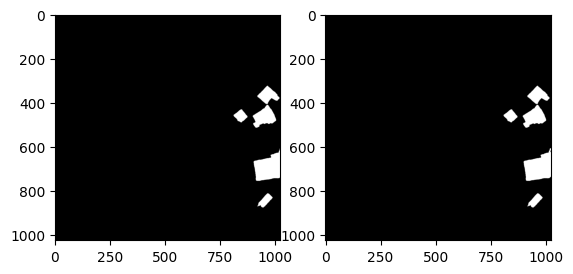

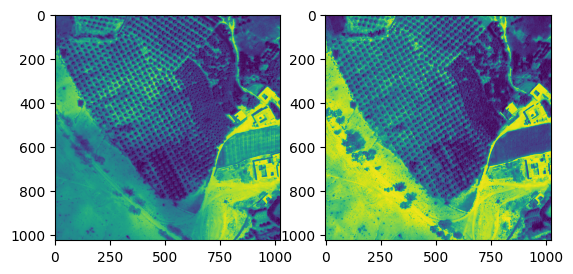

tile complete


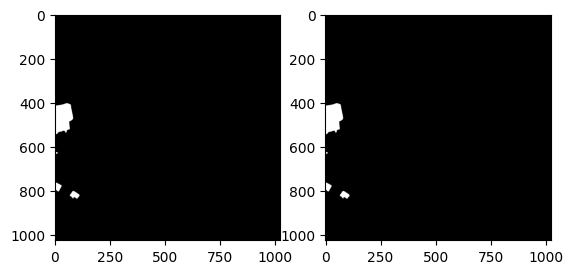

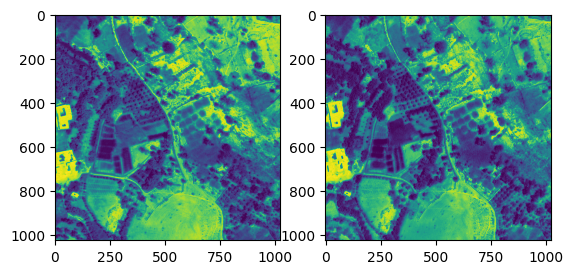

tile complete


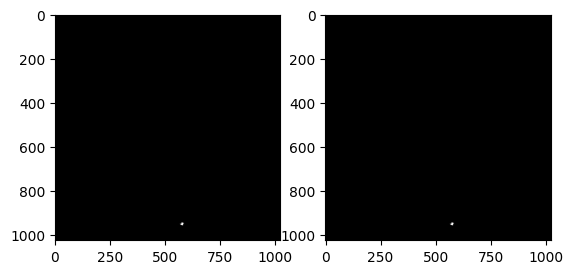

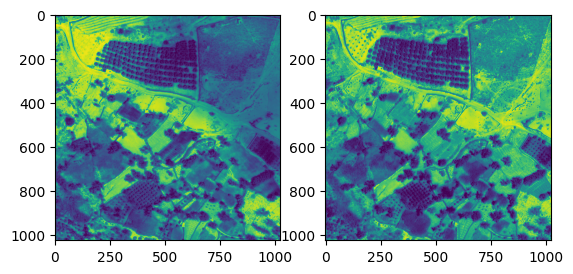

tile complete


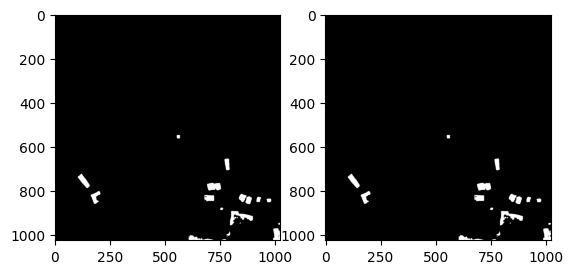

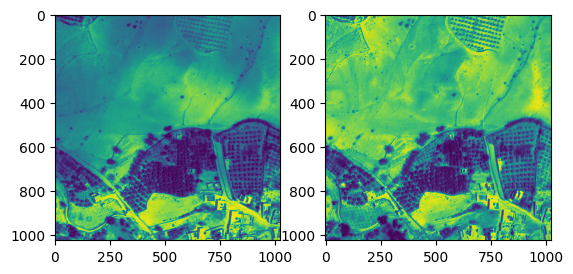

tile complete


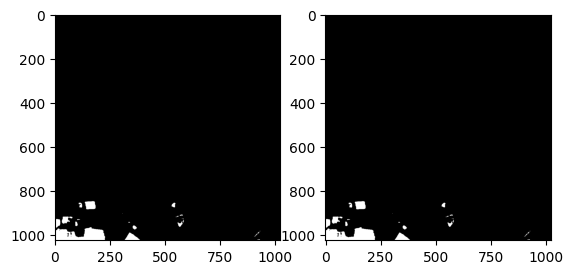

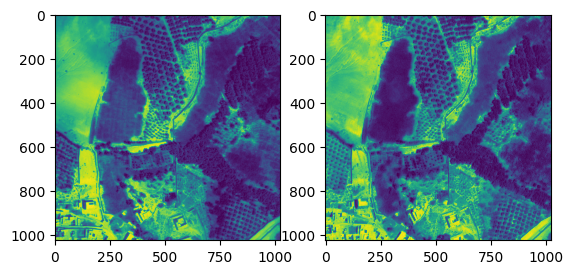

tile complete


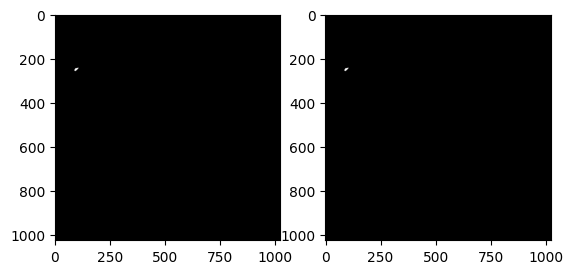

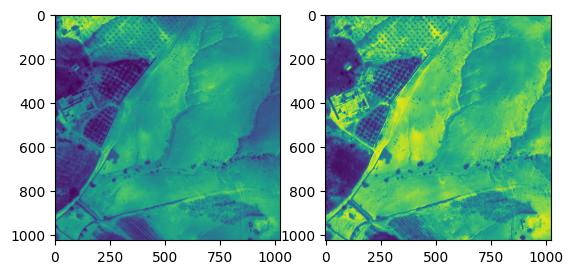

tile complete


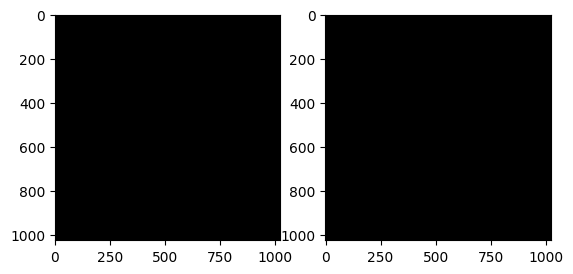

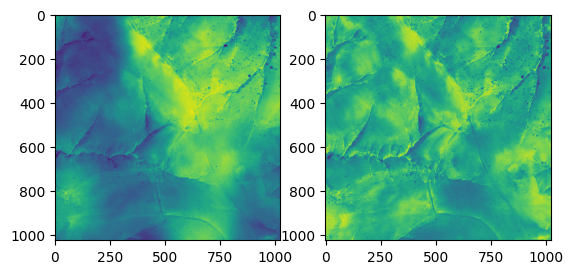

tile complete


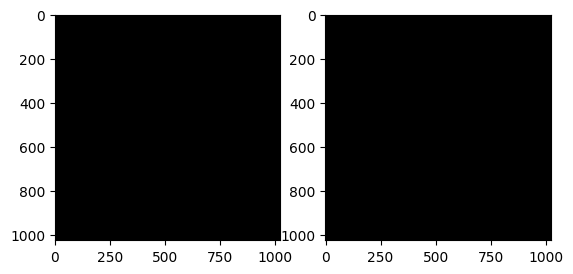

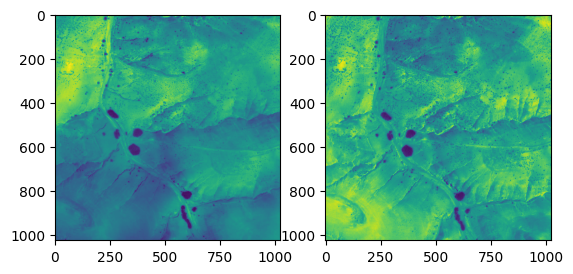

tile complete


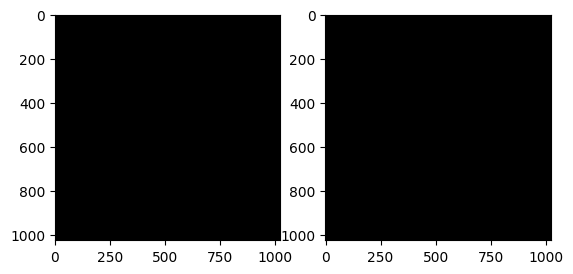

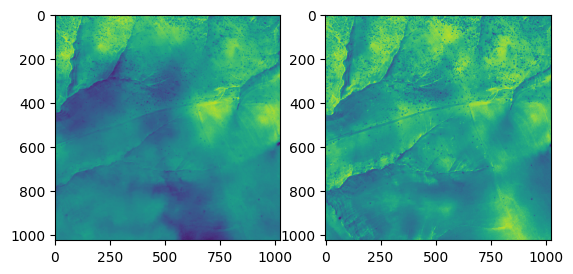

tile complete


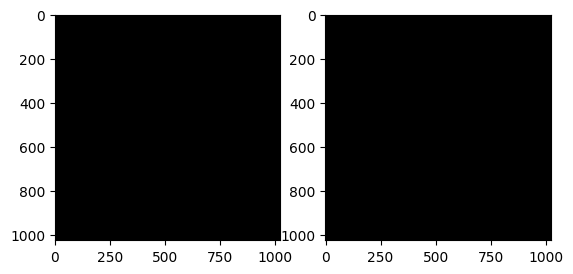

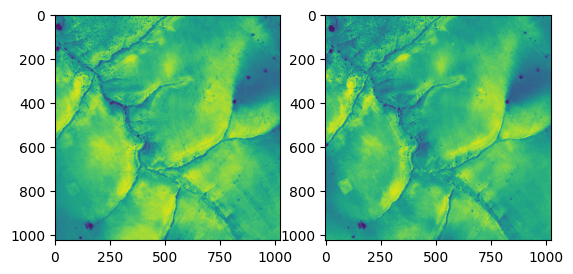

tile complete


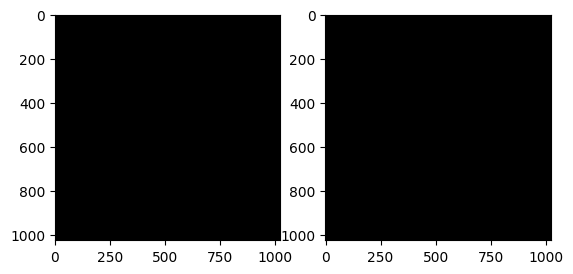

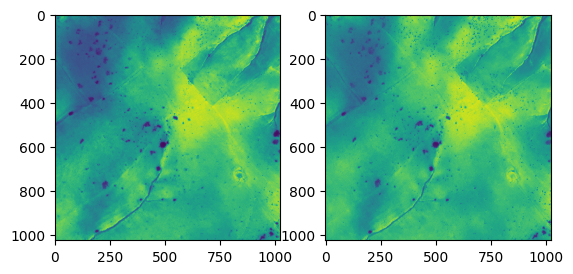

tile complete


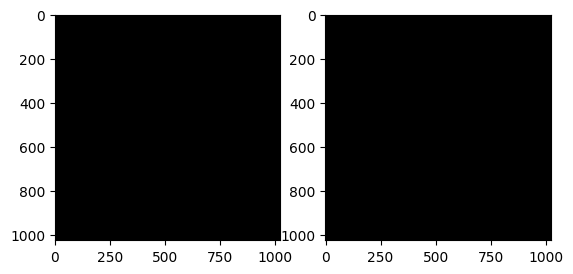

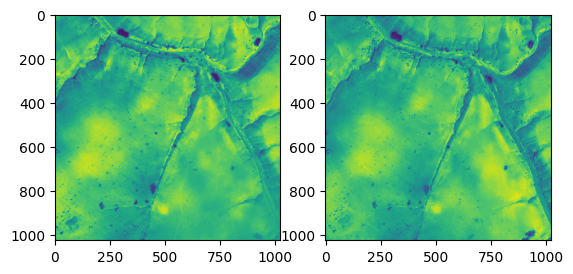

tile complete


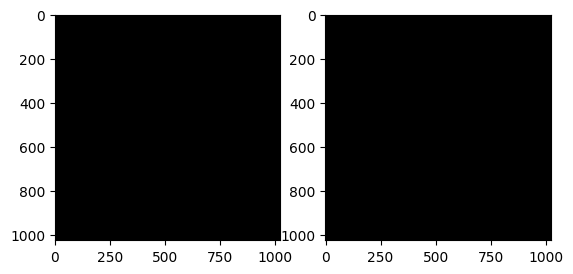

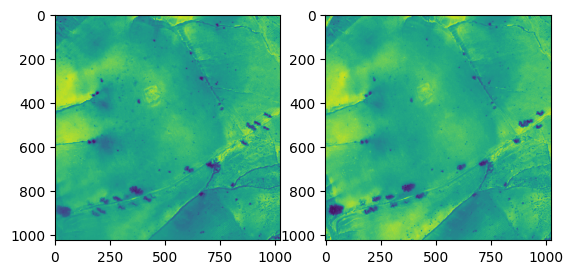

tile complete


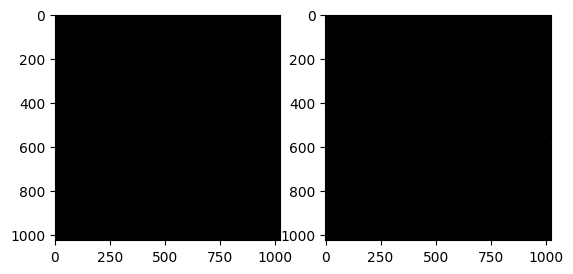

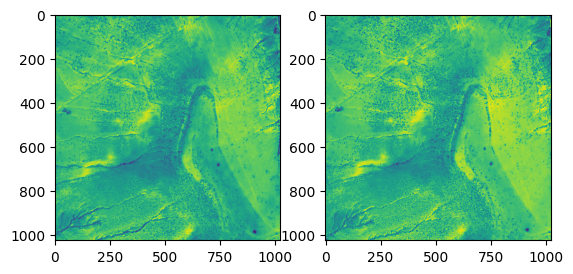

tile complete


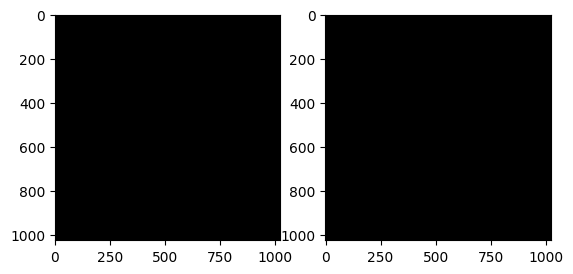

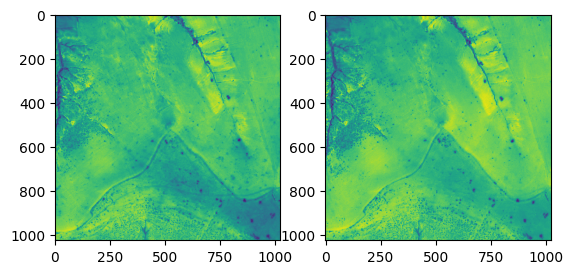

tile complete


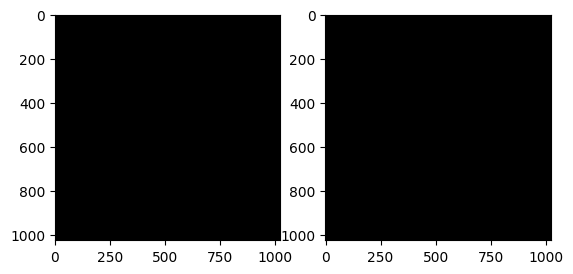

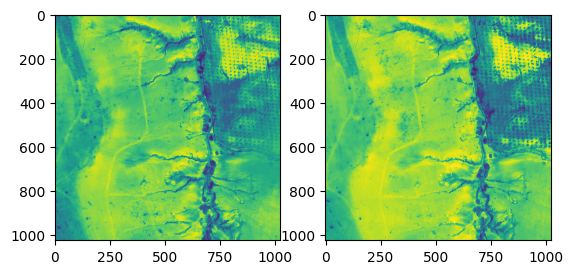

tile complete


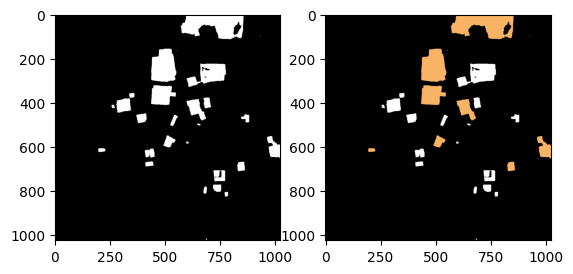

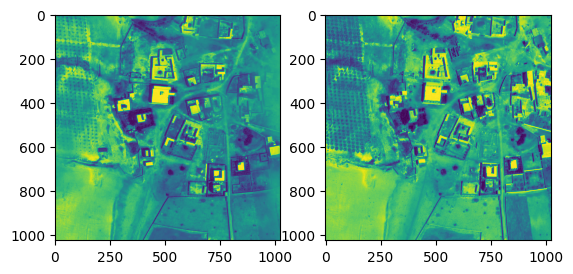

tile complete


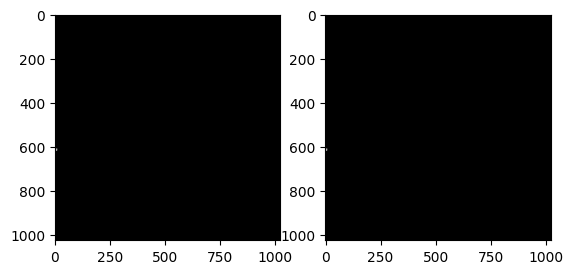

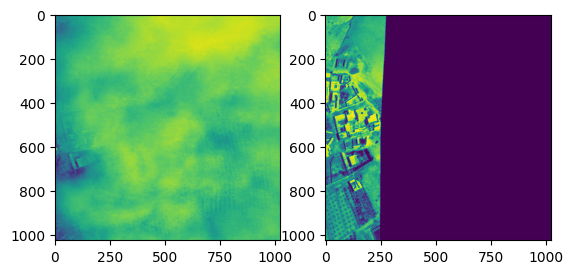

tile complete


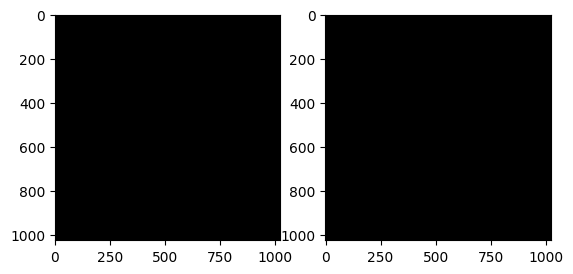

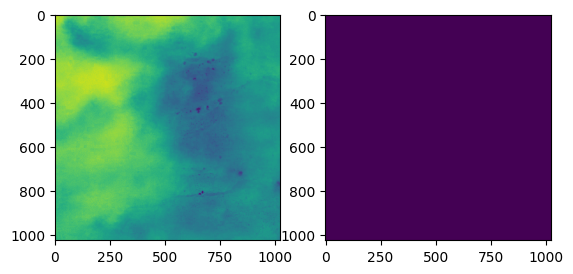

tile complete


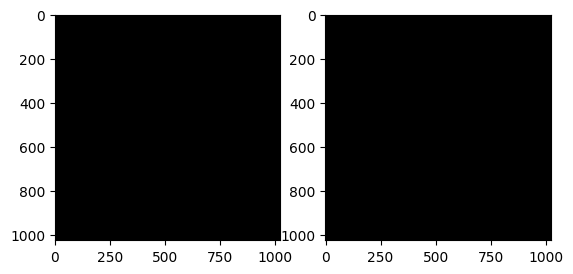

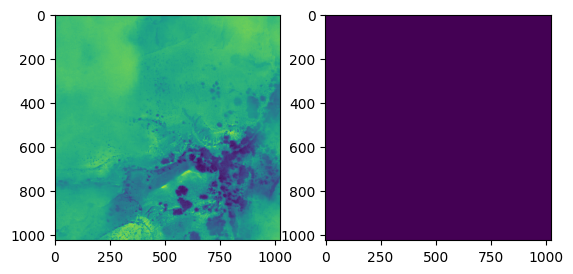

tile complete


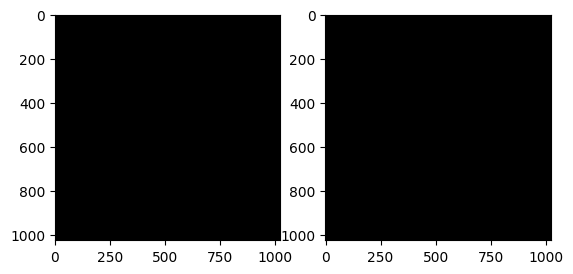

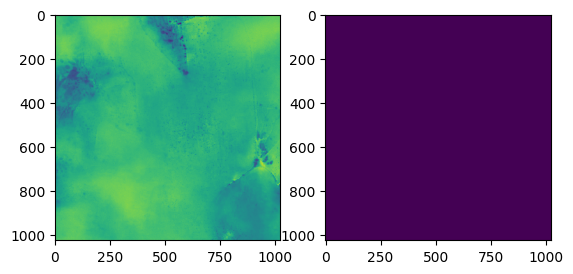

tile complete


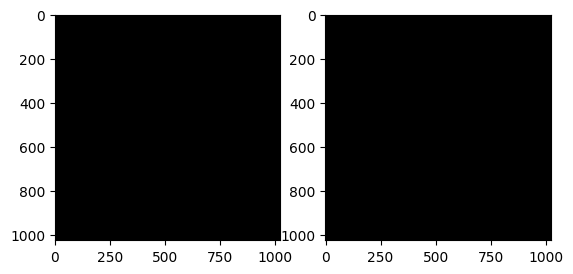

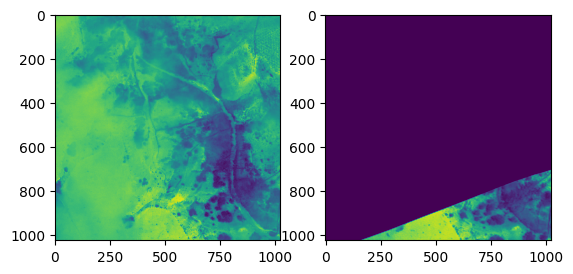

tile complete


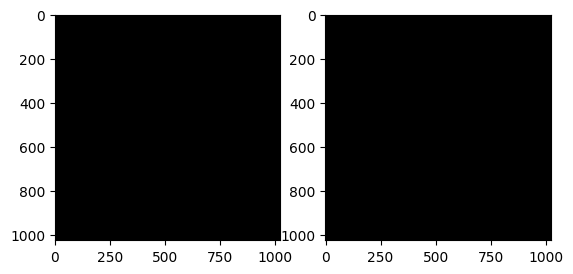

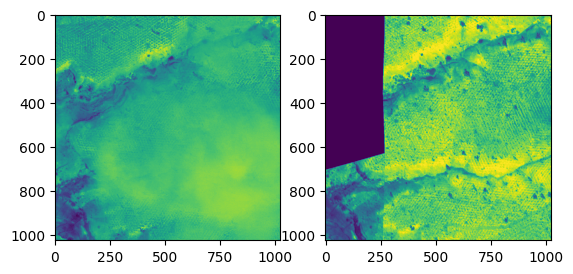

tile complete


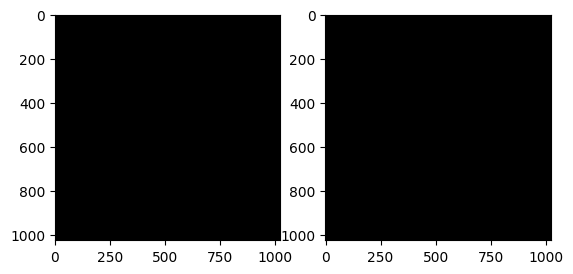

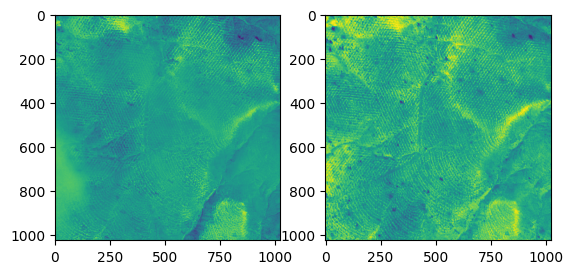

tile complete


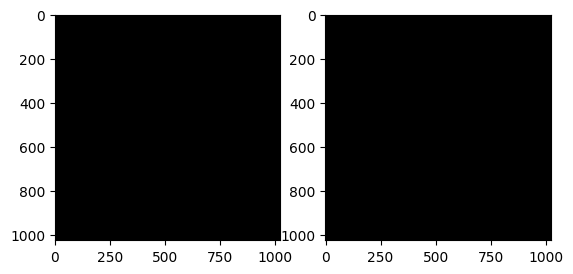

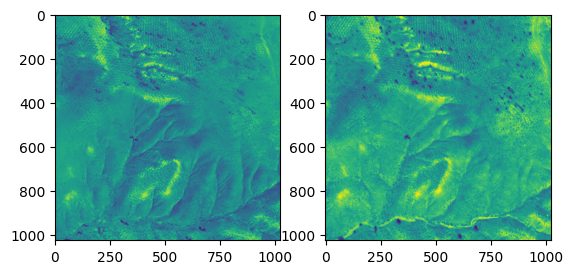

tile complete


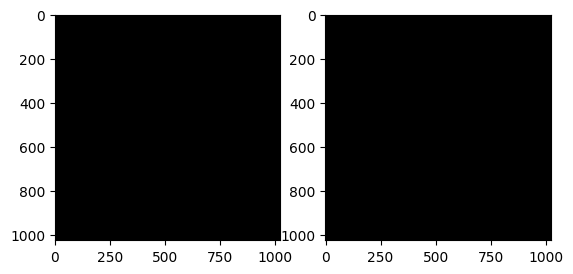

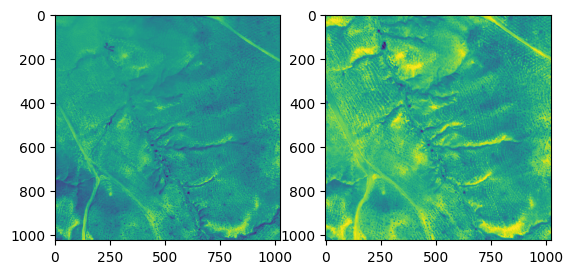

tile complete


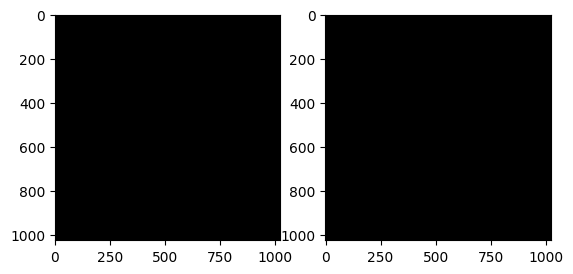

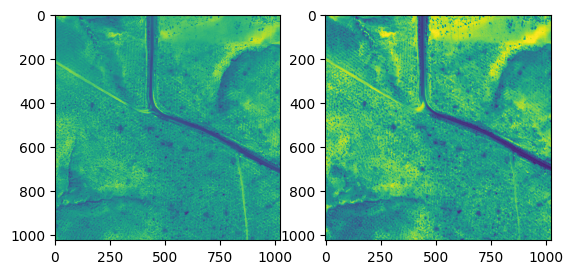

tile complete


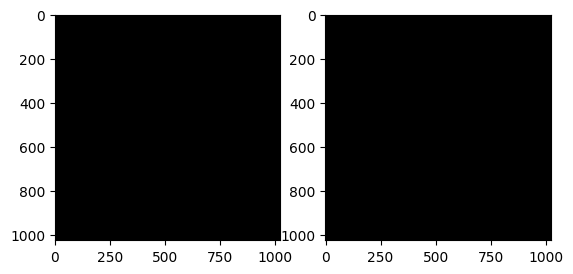

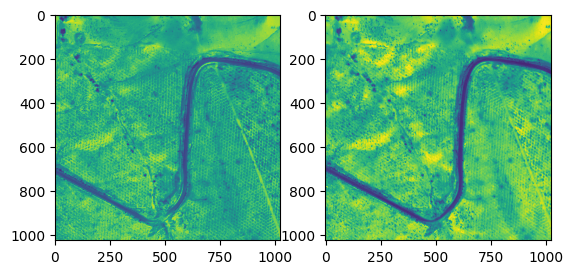

tile complete


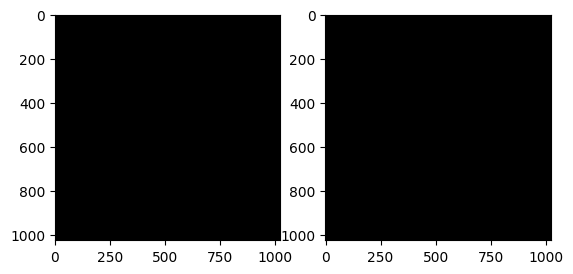

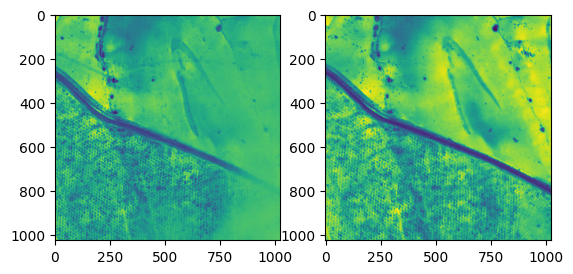

tile complete


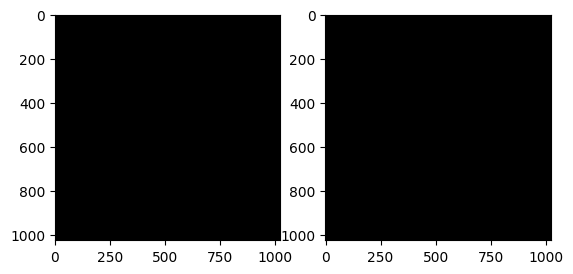

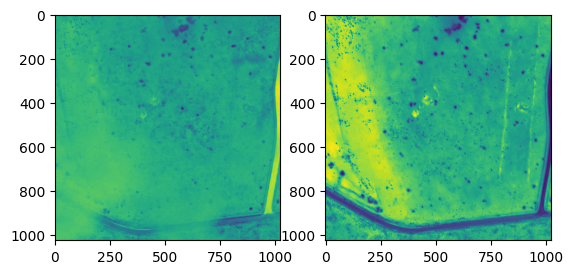

tile complete


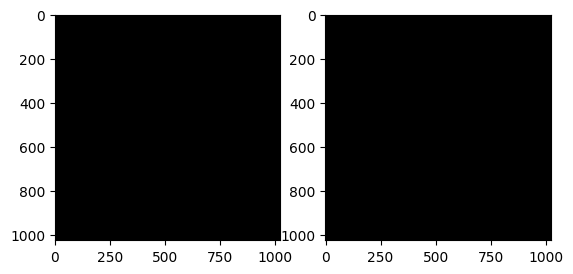

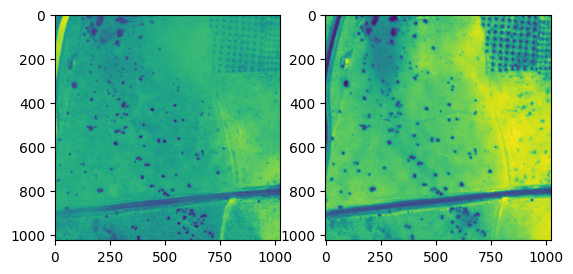

tile complete


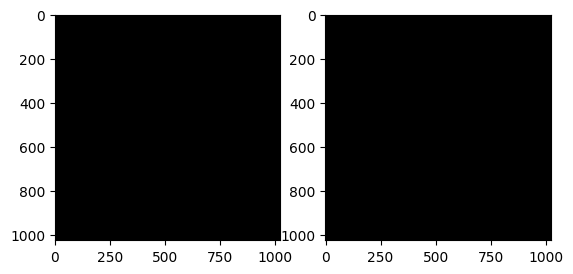

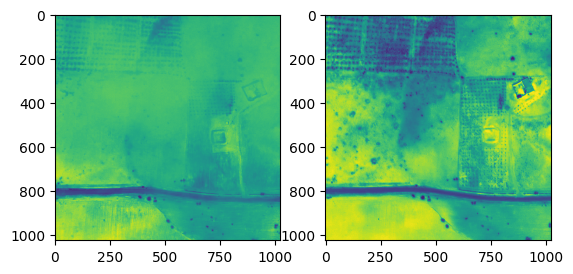

tile complete


KeyboardInterrupt: 

In [59]:
# Run BDA on each tile and concat the results to a geopandas df
import numpy as np
import rasterio
from rasterio import features
from PIL import Image
import changeos
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
from numpy import ma

pre_entire_gdf = gpd.GeoDataFrame(columns=['geometry', 'value'])
post_entire_gdf = gpd.GeoDataFrame(columns=['geometry', 'value'])

# Open the first GeoTIFF file
with rasterio.open('pre_vrt_tiled_v2.tif') as src1:

    # Open the second GeoTIFF file
    with rasterio.open('post_vrt_tiled_v2.tif') as src2:
                  
        # Get the total number of tiles in each image
        num_tiles_src1 = len(list(src1.block_windows(1)))
        num_tiles_src2 = len(list(src2.block_windows(1)))
        
        
        print(src1.crs)

        print(f'Total number of tiles in the first image: {num_tiles_src1}')
        print(f'Total number of tiles in the second image: {num_tiles_src2}')

        # Iterate over each block (tile) in both files
        for (ji1, src_window1), (ji2, src_window2) in zip(src1.block_windows(1), src2.block_windows(1)):
            
            # ji1 and ji2 are the (j, i) indices of the blocks
            # src_window1 and src_window2 are the windows in the source datasets for the corresponding blocks
            
            j1, i1 = ji1  # Separate j and i indices
            j2, i2 = ji2  # Separate j and i indices
            
            # Read the tile data from both files
            pre_tile = src1.read(1, window=src_window1)
            post_tile = src2.read(1, window=src_window2)
            
            # Get transform for each img to be applied to the polygons gdf
            pre_transform = src1.window_transform(src_window1)
            post_transform = src2.window_transform(src_window2)
            
            # Convert the tile to a 3-channel (RGB) image
            pre_tile_rgb = Image.fromarray(pre_tile)

            # Convert the PIL image to a NumPy array
            pre_tile_array = np.array(pre_tile_rgb)

            # Create an empty 3-channel (RGB) array with the same dimensions
            pre_rgb_array = np.empty((pre_tile_array.shape[0], pre_tile_array.shape[1], 3), dtype=np.uint8)

            # Copy the grayscale channel to all three RGB channels
            pre_rgb_array[:,:,0] = pre_tile_array
            pre_rgb_array[:,:,1] = pre_tile_array
            pre_rgb_array[:,:,2] = pre_tile_array

            # Convert the tile to a 3-channel (RGB) image
            post_tile_rgb = Image.fromarray(post_tile)

            # Convert the PIL image to a NumPy array
            post_tile_array = np.array(post_tile_rgb)

            # Create an empty 3-channel (RGB) array with the same dimensions
            post_rgb_array = np.empty((post_tile_array.shape[0], post_tile_array.shape[1], 3), dtype=np.uint8)

            # Copy the grayscale channel to all three RGB channels
            post_rgb_array[:,:,0] = post_tile_array
            post_rgb_array[:,:,1] = post_tile_array
            post_rgb_array[:,:,2] = post_tile_array
      
            # support 'changeos_r18', 'changeos_r34', 'changeos_r50', 'changeos_r101'
            model = changeos.from_name('changeos_r101') # take 'changeos_r101' as example

            pre_disaster_image = pre_rgb_array
            post_disaster_image = post_rgb_array

            # model inference
            loc, dam = model(pre_disaster_image, post_disaster_image)

            #extract polygons from pre
            mask1 = loc!=0
            pre_shapes = rasterio.features.shapes(loc, mask=mask1, connectivity=4, transform=pre_transform)
            pre_fc = ({"geometry": shape, "properties": {"value": value}} for shape, value in pre_shapes)
            pre_img_geodf = gpd.GeoDataFrame.from_features(pre_fc)

            # extract polygons from post
            mask2 = dam!=0
            post_shapes = rasterio.features.shapes(dam, mask=mask2, connectivity=4, transform=post_transform)
            post_fc = ({"geometry": shape, "properties": {"value": value}} for shape, value in post_shapes)
            post_img_geodf = gpd.GeoDataFrame.from_features(post_fc)
            
            loc, dam = changeos.visualize(loc, dam)
            
            #uncomment below to see tile by tile output and original data.
            """
            # visualize by matplotlib
            plt.subplot(121)
            plt.imshow(loc)
            
            plt.subplot(122)
            plt.imshow(dam)
            plt.show()
            
            # visualize by matplotlib - original data tiles
            plt.subplot(121)
            plt.imshow(pre_tile)
            
            plt.subplot(122)
            plt.imshow(post_tile)
            plt.show()
            """
            
            pre_entire_gdf = pd.concat([pre_entire_gdf, pre_img_geodf], ignore_index=True)
            post_entire_gdf = pd.concat([post_entire_gdf, post_img_geodf], ignore_index=True)
            print('tile complete')
    

In [64]:
# print the geodataframes of polygons
#print(pre_entire_gdf)
#print(post_entire_gdf)


                                             geometry  value
0   POLYGON ((560137.024 3470057.068, 560138.245 3...    1.0
1   POLYGON ((560100.403 3470024.414, 560102.539 3...    1.0
2   POLYGON ((560136.414 3470030.823, 560137.634 3...    1.0
3   POLYGON ((560155.334 3469970.703, 560156.250 3...    1.0
4   POLYGON ((560137.634 3469908.447, 560138.245 3...    1.0
..                                                ...    ...
76  POLYGON ((565071.411 3469920.654, 565072.327 3...    1.0
77  POLYGON ((565050.659 3469917.603, 565053.406 3...    1.0
78  POLYGON ((565079.041 3469910.278, 565082.703 3...    1.0
79  POLYGON ((565052.795 3469845.886, 565053.406 3...    1.0
80  POLYGON ((565156.250 3469971.313, 565156.250 3...    1.0

[81 rows x 2 columns]
                                             geometry  value
0   POLYGON ((560137.024 3470057.068, 560138.245 3...    1.0
1   POLYGON ((560100.403 3470024.414, 560102.539 3...    1.0
2   POLYGON ((560136.414 3470030.823, 560137.634 3...    1.0
3

In [80]:
#Folium Map of the Post-event damage. 


import folium
import geopandas as gpd
from folium import plugins
from IPython.display import display
from folium import GeoJson

m = folium.Map(location=(31.7917, -7.0926), zoom_start=5, tiles="cartodb positron")
gdf = post_entire_gdf
gdf = gdf.set_crs(epsg=32629)
gdf = gdf.to_crs(epsg=4326)
geojson_data = gdf.to_json()
GeoJson(geojson_data).add_to(m)


tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)
m


Left to do:
1. Apply colour ramp to folium map based on damage level (value column in gdf)
2. Run for all tiles / reduce study area.
3. Use Maxar Post event Tiles instead of ESRI basemap or use Post_event_tiff
3. Maybe try changing the study area / event to see if it performs better (on new branch in the github)